In [ ]:
!pip install scikit-dimension
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
!cp 'drive/MyDrive/optimizer/data/R14.zip' R14.zip

In [ ]:
!unzip R14.zip

Archive:  R14.zip
replace R14.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!head R14.txt

4 50000 5 5 0
1 1 1 1 1
260.874617961654450 -11.074015931188864 -31.937055959914559 -86.974392830212068
257.143417456671560 -11.713995017568594 -30.031099829022246 -89.505484663508526
243.858608945004930 -2.148497187948407 -36.208420827061069 -83.648976302414823
245.836272803356450 -7.078722721892051 -23.609197260812266 -68.942147448676494
257.552367999638250 -14.518605263565551 -26.708449875252050 -92.042528316043644
240.132839297730240 -1.126504779954136 -30.212870097767116 -69.503107700165998
256.875163427794580 -8.767736915070001 -33.092022248623742 -86.015235548215017
248.381659231523740 -15.734766356142114 -21.252686024394219 -94.608755720602801


In [ ]:
with open('R14.txt') as fp:
  line = fp.readline()
  line = line.split(' ')
  d, n, m, k, p = [int(item) for item in line]
  line = fp.readline()
  line = line.split(' ')
  K = [int(item) for item in line]


In [ ]:
!tail -n +3 R14.txt > R14_clean.txt

In [ ]:
vectors = np.fromfile('R14_clean.txt', sep=' ').reshape(n, -1)

In [ ]:
vectors

array([[ 260.87461796,  -11.07401593,  -31.93705596,  -86.97439283],
       [ 257.14341746,  -11.71399502,  -30.03109983,  -89.50548466],
       [ 243.85860895,   -2.14849719,  -36.20842083,  -83.6489763 ],
       ...,
       [ 242.48607339,   -7.24154497,  -20.95069986,  -67.44231576],
       [ 184.65839054,  -35.13423594,  -76.81411826, -118.13279221],
       [ 257.54034916,  -11.04759466,  -23.61650369,  -70.46063614]])

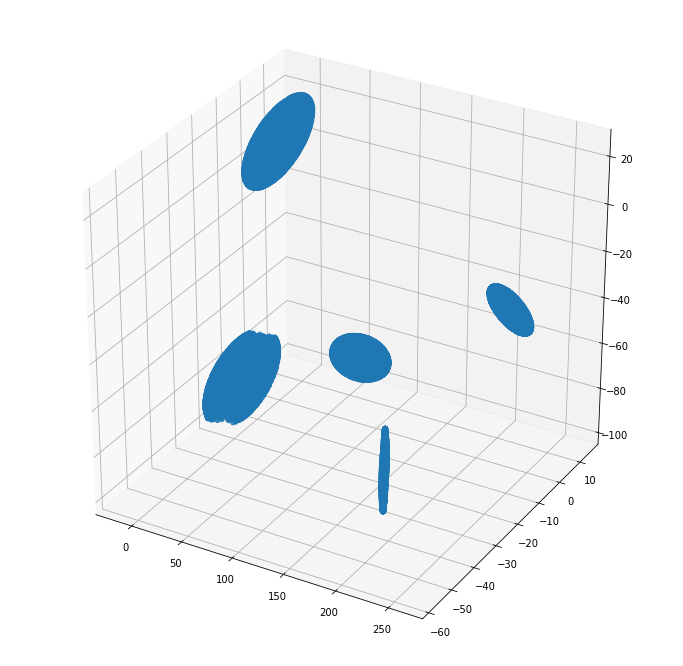

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2])
_ = plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = GaussianMixture(n_components=k, covariance_type='spherical', 
                      random_state=0, n_init=32, max_iter=10000, tol=1e-7)
gmm.fit(vectors)



GaussianMixture(covariance_type='spherical', max_iter=10000, n_components=5,
                n_init=32, random_state=0, tol=1e-07)

In [ ]:
gmm.means_

array([[ 247.68548657,   -8.59980445,  -27.08035959,  -81.62709147],
       [  61.62462282,  -41.0766909 ,  -50.55175105,   11.9399921 ],
       [ 184.99532796,  -35.10798653,  -81.19733719, -124.27438491],
       [   0.67702561,    0.35861824,    8.73108494,   13.77762411],
       [ 123.74989091,  -18.2346417 ,  -54.32722788,  -57.58691663]])

In [ ]:
def top_k_outliers(vectors, k):
  scores = gmm.score_samples(vectors)
  top_k = np.argpartition(-scores, -k)[-k:]
  return top_k, scores[top_k]

In [ ]:
outlier_ind, _ = top_k_outliers(vectors, p)

In [ ]:
labels = gmm.predict(vectors)
if p > 0:
  labels[outlier_ind] = -1

In [ ]:
labels

array([0, 0, 0, ..., 0, 2, 0])

In [ ]:
from numba import njit, jit

@jit
def noisy_center_radius(points, k):
  dist_matrix = np.zeros((points.shape[0], points.shape[0]))
  for i in range(points.shape[0]):
    for j in range(i):
      dist = np.linalg.norm(points[i] - points[j])
      dist_matrix[i, j] = dist
  dist_matrix = dist_matrix.reshape(-1)
  top_k_dist = np.argsort(dist_matrix)[-k:]
  rows = top_k_dist // points.shape[0]
  cols = top_k_dist % points.shape[0]
  center = 0.5*(points[cols] + points[rows]).mean(axis=0)
  radius = dist_matrix[top_k_dist].mean()/2
  return center, radius

def center_radius(points):
  dist = torch.cdist(points, points)
  ind = dist.argmax()
  row = (torch.div(ind, points.size(0), rounding_mode='floor')).item()
  col = (ind % points.size(0)).item()
  radius = (dist[row, col]/2).item()
  center = 0.5 * (points[row] + points[col])
  return center, radius


manifold_center = []
manifold_radius = []

for sphere in tqdm(range(k)):
  # points = torch.from_numpy(vectors[labels==sphere])
  points = vectors[labels==sphere]
  center, radius = noisy_center_radius(points, 64)
  manifold_center.append(center)
  manifold_radius.append(radius)

manifold_center = np.vstack(manifold_center)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
gmm.means_

array([[ 247.68548657,   -8.59980445,  -27.08035959,  -81.62709147],
       [  61.62462282,  -41.0766909 ,  -50.55175105,   11.9399921 ],
       [ 184.99532796,  -35.10798653,  -81.19733719, -124.27438491],
       [   0.67702561,    0.35861824,    8.73108494,   13.77762411],
       [ 123.74989091,  -18.2346417 ,  -54.32722788,  -57.58691663]])

In [ ]:
manifold_radius

[16.084838904827468,
 16.085285626295025,
 16.089088421455443,
 16.08647762591705,
 16.08557915961447]

In [ ]:
manifold_center

array([[ 2.46978954e+02, -8.44789427e+00, -2.69745411e+01,
        -8.16410083e+01],
       [ 6.18324512e+01, -4.15514098e+01, -5.11846994e+01,
         1.19387280e+01],
       [ 1.85247170e+02, -3.52576898e+01, -8.05155567e+01,
        -1.24343733e+02],
       [ 1.13063287e-01,  7.38237999e-01,  9.03144104e+00,
         1.38469734e+01],
       [ 1.23567386e+02, -1.78369659e+01, -5.51207967e+01,
        -5.75490674e+01]])

In [ ]:
from scipy.optimize import minimize, differential_evolution

@njit
def loss_center_given_radius(center, points, radius):
  return (((points - center)**2).sum(axis=1) > radius**2).sum()

@jit
def estimate_corrected_radius(sphere):
  b1 = manifold_center[sphere, :] - .5
  b2 = manifold_center[sphere, :] + .5
  bounds = [(b1[i], b2[i]) for i in range(4)]
  result = differential_evolution(func=loss_center_given_radius,
                        bounds=bounds, maxiter=1500, popsize=128,
                        args=(vectors[labels==sphere], 16.09))
  print(result)
  center = result.x
                        
  return center

In [ ]:
manifold_corrected_center = np.vstack([estimate_corrected_radius(sphere) for sphere in tqdm(range(k))])

  0%|          | 0/5 [00:00<?, ?it/s]

     fun: 112.0
 message: 'Optimization terminated successfully.'
    nfev: 30213
     nit: 58
 success: True
       x: array([246.95389123,  -8.4702757 , -27.02126288, -81.6184977 ])
     fun: 112.0
 message: 'Optimization terminated successfully.'
    nfev: 27141
     nit: 52
 success: True
       x: array([ 61.8352135 , -41.51426916, -51.1929812 ,  11.92710705])
     fun: 135.0
 message: 'Optimization terminated successfully.'
    nfev: 22021
     nit: 42
 success: True
       x: array([ 185.25366702,  -35.22068062,  -80.50168978, -124.36514676])
     fun: 131.0
 message: 'Optimization terminated successfully.'
    nfev: 26117
     nit: 50
 success: True
       x: array([ 0.12066251,  0.72363456,  8.950088  , 13.80227843])
     fun: 118.0
 message: 'Optimization terminated successfully.'
    nfev: 27653
     nit: 53
 success: True
       x: array([123.54384616, -17.86570555, -55.04994486, -57.59393565])


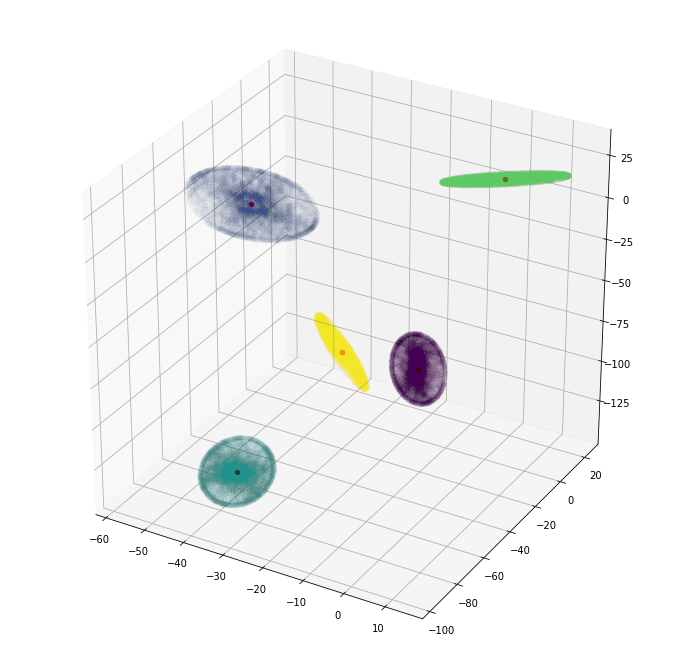

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# t_colors = (S.flatten().abs() < 0.1).numpy() * 1
# ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=t_colors)
ax.scatter(vectors[:, 1], vectors[:, 2], vectors[:, 3], c=labels, alpha=0.01)
for sphere in range(k):
  ax.scatter(manifold_corrected_center[sphere, 1], manifold_corrected_center[sphere, 2], manifold_corrected_center[sphere, 3], c='red')

_ = plt.show()

In [ ]:
import skdim.id as intd

manifold_dims = []

for sphere in tqdm(range(k)):
  lpca = intd.lPCA().fit_pw(vectors[labels==sphere], n_neighbors = 64, n_jobs = 1)
  manifold_dims.append(int(np.round(lpca.dimension_pw_.mean())))
  

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
manifold_dims

[3, 3, 3, 3, 3]

In [ ]:
from numba import njit

@njit
def get_best_fitting_plane_vector(centered):

    # Calculate the covariance matrix of the coordinates
    covariance_matrix = np.cov(centered, rowvar=False) # Variables = columns

    # Calculate the eigenvalues & eigenvectors of the covariance matrix
    e_val, e_vect = np.linalg.eig(covariance_matrix)

    # The normal vector to the plane is the eigenvector associated to the minimum eigenvalue
    min_eval = np.argmin(e_val)
    normal_vector = e_vect[:, min_eval]

    return normal_vector

In [ ]:
affine_a = []
affine_b = []

for sphere in tqdm(range(k)):
  points = vectors[labels==sphere]
  shift = points.mean(axis=0)
  centered = points - shift
  a = get_best_fitting_plane_vector(centered)
  b = a @ shift
  affine_a.append(a)
  affine_b.append(b)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
affine_a

[array([ 0.24868911,  0.79848253,  0.50890912, -0.20393842]),
 array([0.96518026, 0.13757317, 0.21630663, 0.05207805]),
 array([-0.46868729, -0.88318327, -0.01144044, -0.01373534]),
 array([ 0.00071218, -0.57413705,  0.5407358 ,  0.61479341]),
 array([ 0.13324384, -0.82753489, -0.45127147, -0.30624525])]

In [ ]:
affine_b

[57.59534819130016,
 43.514951865221576,
 -53.06228811120818,
 12.986188888170368,
 73.73076053825065]

In [ ]:
with open('output.txt', 'w+') as fp:
  fp.write(f'{n} {k}\n')
  for sphere in range(k):
    fp.write(f'{manifold_dims[sphere]} {K[sphere]} Sphere\n')
    fp.write(' '.join(affine_a[sphere].astype(str).tolist()) + '\n')
    fp.write(f'{affine_b[sphere]}\n')
    vec_ind = np.where(labels == sphere)[0]
    fp.write(' '.join(manifold_corrected_center[sphere, :].astype(str).tolist()) + f' {manifold_radius[sphere]} \n')
    fp.write(f'{len(vec_ind)} ')
    fp.write(' '.join((vec_ind+1).astype(str).tolist()))
    fp.write('\n')
  fp.write(f'{p}')
  if p > 0:
    fp.write(' ' + ' '.join((outlier_ind+1).astype(str).tolist()))